In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from kid_readout.interactive import *

INFO     2016-11-29 13:07:31,763 - kid_readout.<module>:13  kid_readout logging setup with default stream handler


In [3]:
import glob

In [4]:
import joblib
import pandas as pd

In [5]:
import seaborn as sns
sns.set_context('paper')
sns.set(font_scale=1.5)

In [6]:
fns = glob.glob('/artemis/readout/2016-11-2[345]*')


fns.sort()
fns = fns[3:] #disregard first three files with mis-matched coarse and fine sweeps

In [7]:
len(fns)

32

In [8]:
def get_df(fn):
    try:
        ncf = NCFile(fn)
#        print fn
        swa = basic.SweepArray(ncf.SweepArray0.stream_arrays+ncf.SweepArray1.stream_arrays)
        ssa = basic.SweepStreamArray(swa,ncf.StreamArray2)
        rows = []
        for number in range(ssa.num_channels):
            ss = ssa.sweep_stream(number)
            ss.set_S(detrend=mlab.detrend_linear,NFFT=2**18)
            rows.append(ss.to_dataframe())
        return pd.concat(rows,ignore_index=True)
    except Exception as e:
#        print "bad:",fn,e
        return None


In [9]:
pp = joblib.Parallel(n_jobs=20,verbose=5)

In [10]:
rows = pp([joblib.delayed(get_df)(fn) for fn in fns])

[Parallel(n_jobs=20)]: Done  32 out of  32 | elapsed:  2.2min finished


In [11]:
rows = [row for row in rows if row is not None]

In [12]:
len(rows)

32

In [13]:
df = pd.concat(rows,ignore_index=True)

In [132]:
df.roach_dac_attenuation.value_counts()

42.0    64
39.0    64
36.0    64
33.0    56
30.0     8
Name: roach_dac_attenuation, dtype: int64

In [14]:
df.shape

(256, 66)

In [15]:
from kid_readout.equipment import starcryo_temps
#reload(starcryo_temps)
#reload(starcryo_temps.kid_readout.analysis.resources.experiments.starcryo_experiments)

updated file list


In [16]:
pkg,pkg2,load,_=starcryo_temps.get_temperatures_at(df.start_epoch)

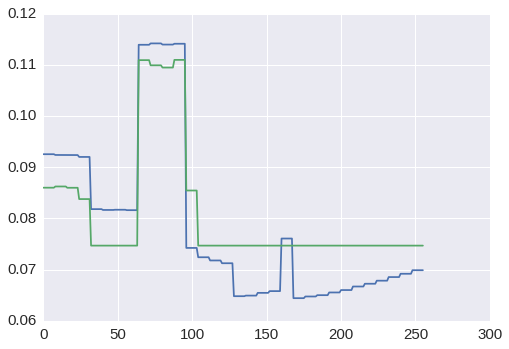

In [17]:
plot(pkg)
plot(pkg2)

In [18]:
df['package_temperature'] = pkg

In [19]:
valid = df[df.number<6]

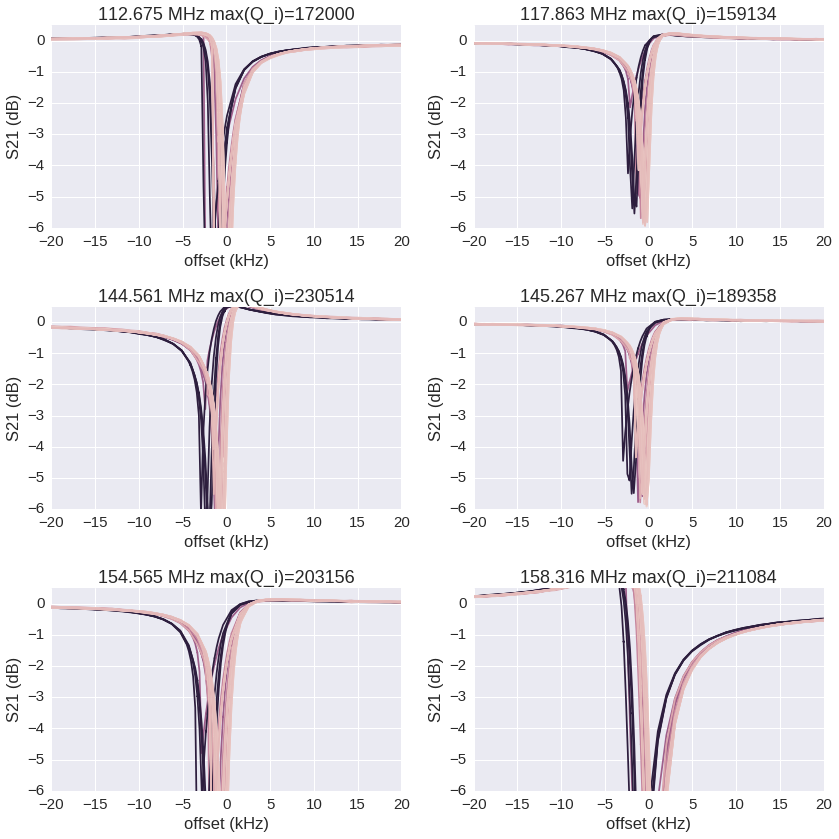

In [20]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               color = get_color(row.package_temperature),
                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(-20,20)
    ax.set_ylim(-6,0.5)
    ax.set_ylabel('S21 (dB)')
    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

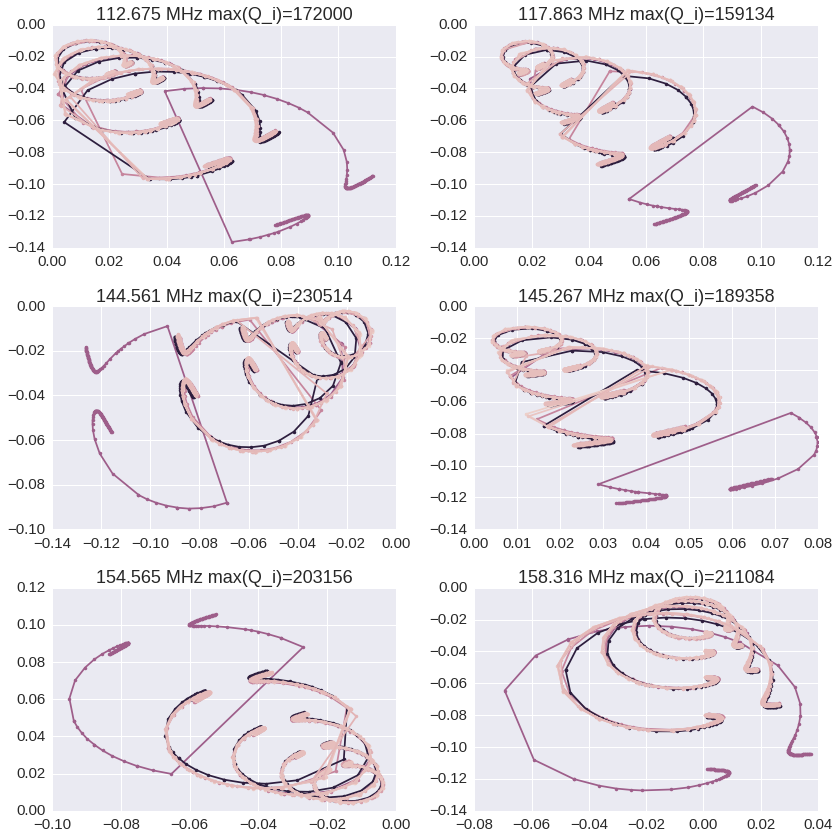

In [21]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        plot_ri(row.res_s21_data,'.-',ax=ax,color=get_color(row.package_temperature))
#        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
#               color = get_color(row.package_temperature),
#                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    #ax.set_xlim(-200,50)
#    ax.set_ylim(-6,0.5)
#    ax.set_ylabel('S21 (dB)')
#    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

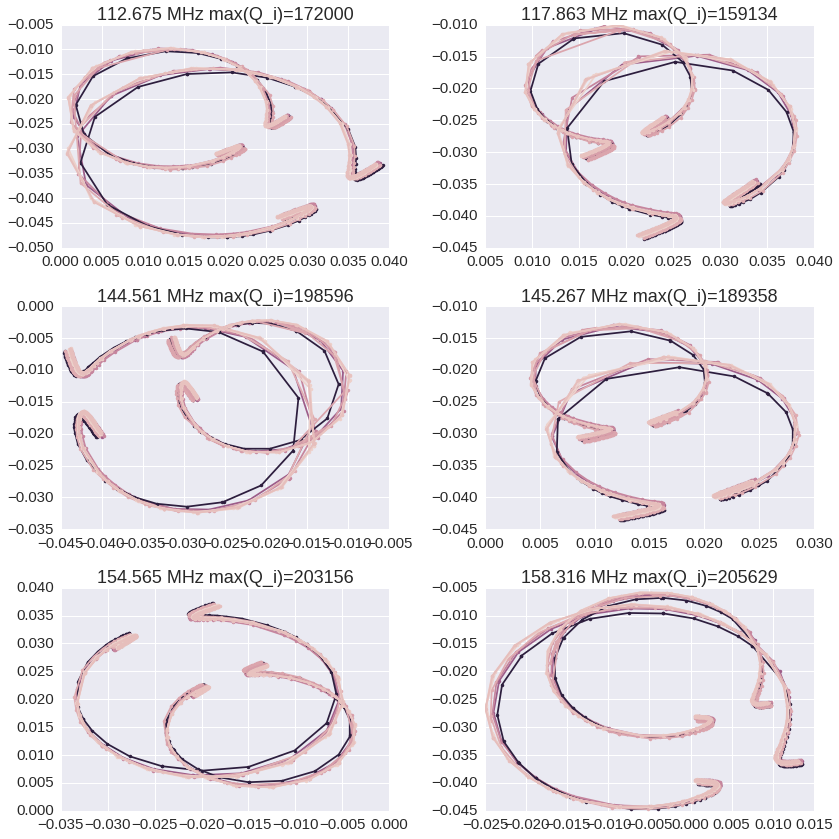

In [22]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation>=39)]
    for m,row in dd.iterrows():
        plot_ri(row.res_s21_data,'.-',ax=ax,color=get_color(row.package_temperature))
#        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
#               color = get_color(row.package_temperature),
#                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    #ax.set_xlim(-200,50)
#    ax.set_ylim(-6,0.5)
#    ax.set_ylabel('S21 (dB)')
#    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

In [102]:
dd = df[(df.number==5) & (df.roach_dac_attenuation==42)]

In [103]:
dd.shape

(8, 68)

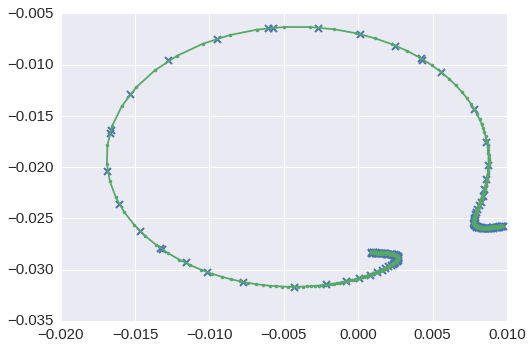

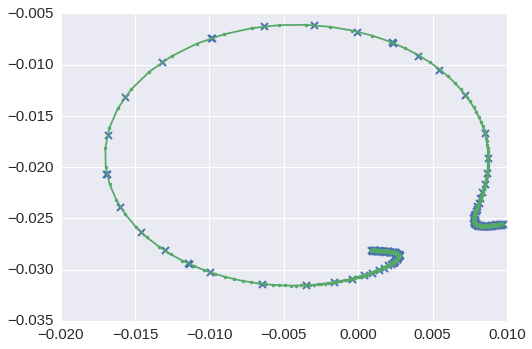

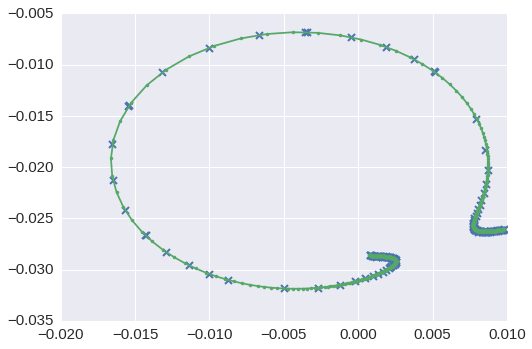

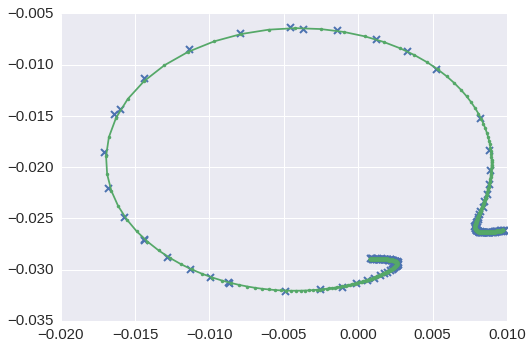

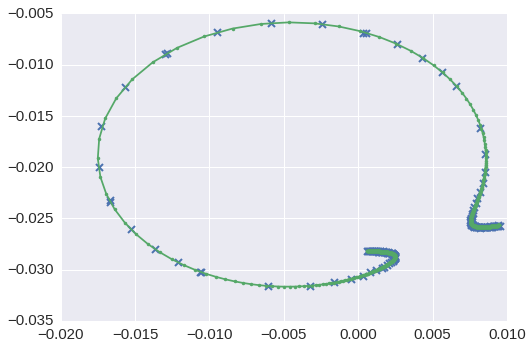

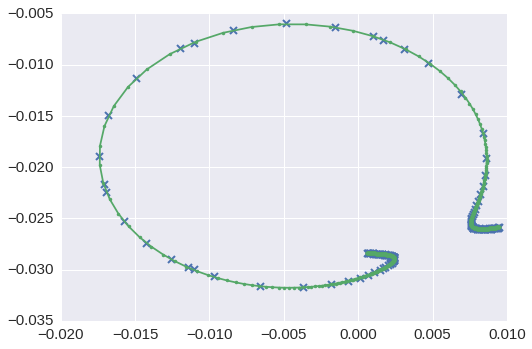

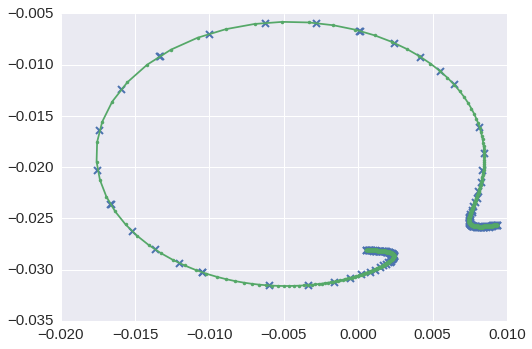

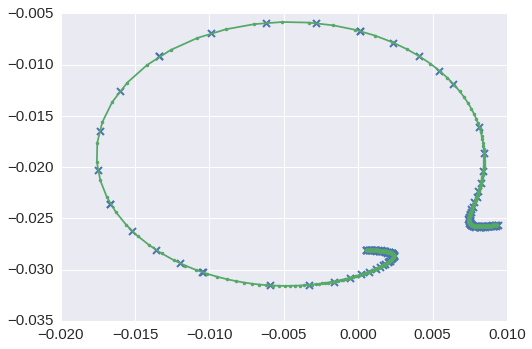

In [104]:
for k,row in dd.iterrows():
    figure()
    plot_ri(row.res_s21_data,'x',mew=2)
    plot_ri(row.res_model_s21,'.-')

In [67]:
from kid_readout.analysis.resonator import fit_resonator

In [72]:
fit_resonator??


In [97]:
alist = []
for k,row in df.iterrows():
    _,bif,_=fit_resonator(row.res_frequency_data,row.res_s21_data,errors=row.res_s21_errors)
    alist.append(bif.a)
alist = np.array(alist)

In [98]:
df['a_bif'] = alist

In [204]:
estar = (2*10**(-dd.roach_dac_attenuation/10.))*dd.res_Q**3/(dd.a_bif*dd.res_f_0*2*np.pi/np.real(1/dd.res_Q_e))

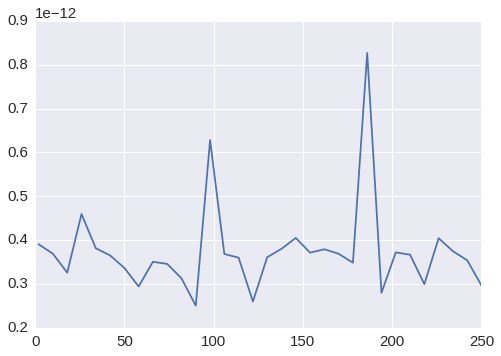

In [216]:
plot((p0mw/1000)*2*10**(-dd.roach_dac_attenuation/10.)*dd.res_Q**3/(dd.a_bif*dd.res_f_0*2*np.pi/np.real(1/dd.res_Q_e)))

In [207]:
estarm = np.mean(estar)

In [208]:
estarm

0.0059368707744669015

In [203]:
10*np.log10(p0mw/1000)

-102.0

In [191]:
estarm*p0mw/1000

3.745912218379703e-13

In [217]:
8.7e-14/_191

0.23225317340092905

In [219]:
np.sqrt(_217)

0.48192652282368631

In [198]:
2*35000*0.04

2800.0

In [192]:
pgnl = 0.8*150e3*144.5e6*2*np.pi*estarm/(2*80e3**3)

In [193]:
10*np.log10(pgnl)

-31.995133992298875

In [194]:
p0mw = 10**((-22-40-10)/10.0)

In [195]:
10*np.log10(p0mw)-42

-114.0

In [196]:
p0mw

6.30957344480193e-08

In [197]:
10*np.log10(pgnl*p0mw)

-103.99513399229888

In [156]:
dd.res_f_0.mean()

144560085.51202396

In [150]:
dd = df[df.number==2]

In [161]:
dd.res_Q.mean()

86388.36903776824

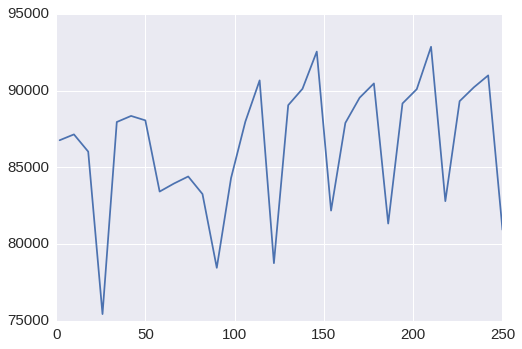

In [152]:
plot(dd.res_Q)

(0, 200000.0)

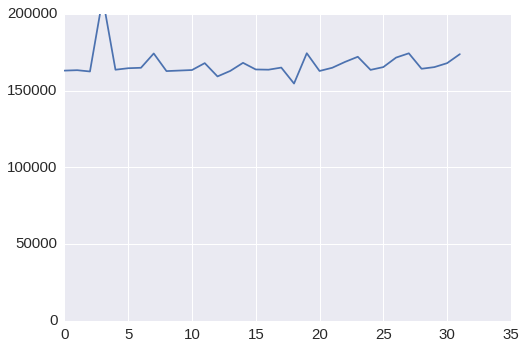

In [153]:
plot(1/np.real(1/dd.res_Q_e))
ylim(0,200e3)

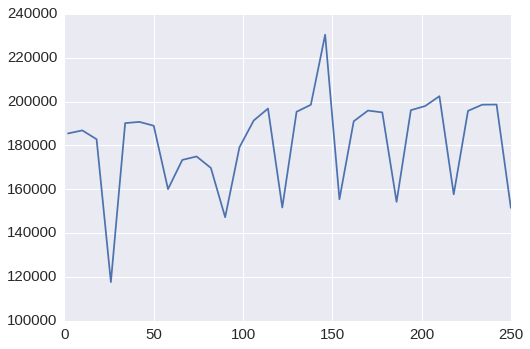

In [155]:
plot(dd.res_Q_i)

In [143]:
plot(((df.res_Q**3/(0.8*df.res_f_0/np.real(1/df.res_Q_e)))/estar.mean())

SyntaxError: unexpected EOF while parsing (<ipython-input-143-12fd902dedc4>, line 1)

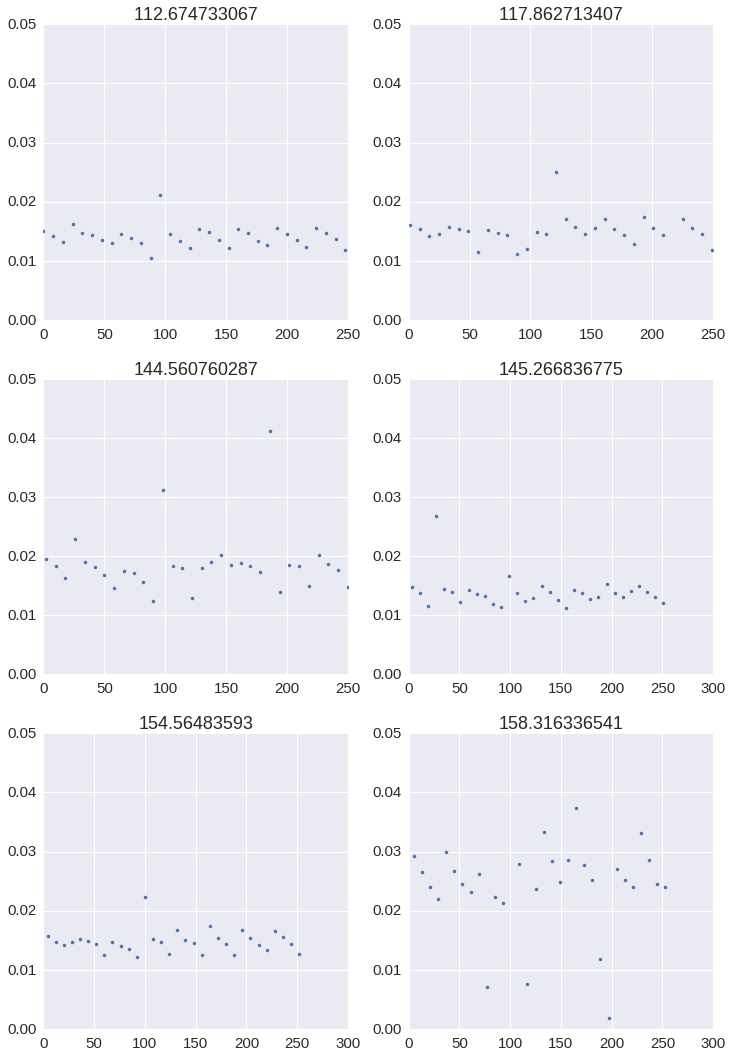

In [133]:
fig,axs = subplots(3,2,figsize=(12,18))
for k,ax in enumerate(axs.flatten()):
    dd = df[df.number==k]
    ax.plot((10**(-dd.roach_dac_attenuation/10.))*dd.res_Q**3/(dd.a_bif*dd.res_f_0/np.real(1/dd.res_Q_e)),'.')
    ax.set_ylim(0,0.05)
    ax.set_title(str(dd.res_f_0.max()/1e6))

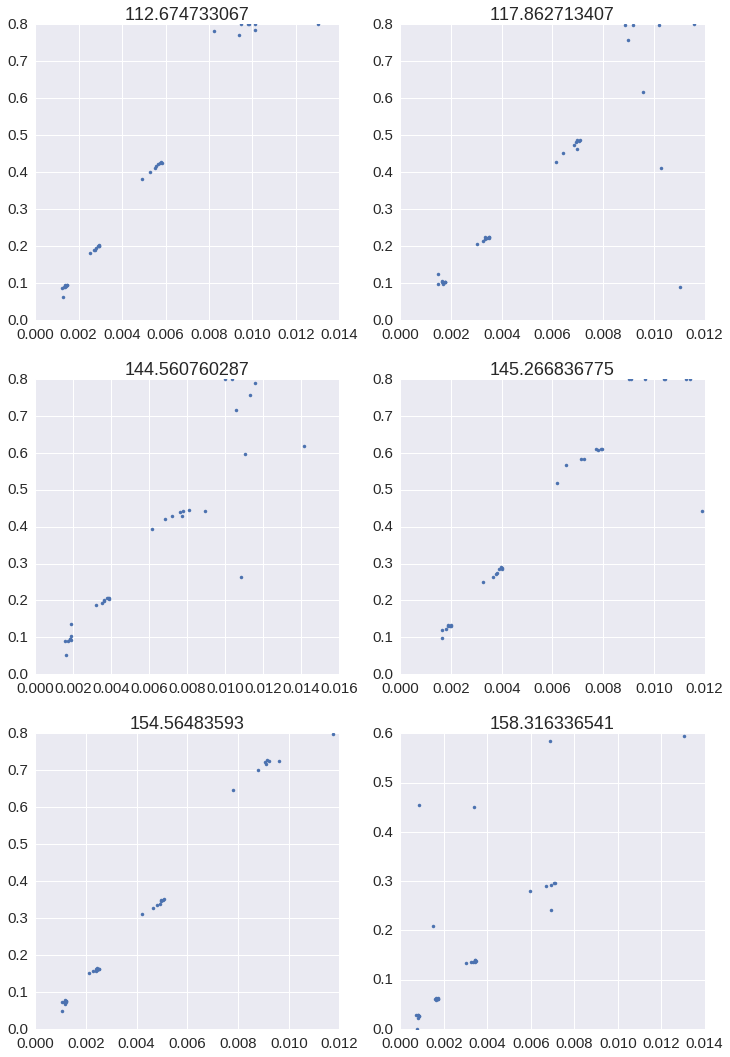

In [135]:
fig,axs = subplots(3,2,figsize=(12,18))
for k,ax in enumerate(axs.flatten()):
    dd = df[df.number==k]
    ax.plot((10**(-dd.roach_dac_attenuation/10.))*dd.res_Q**3/(dd.res_f_0/np.real(1/dd.res_Q_e)),dd.a_bif,'.')
    #ax.set_ylim(0,0.05)
    ax.set_title(str(dd.res_f_0.max()/1e6))

In [105]:
_,bif,_=fit_resonator(row.res_frequency_data,row.res_s21_data,errors=row.res_s21_errors)

In [106]:
bif.a

0.025501930245470119

In [108]:
bif.result.redchi

1.2179091345661182

In [77]:
bif??

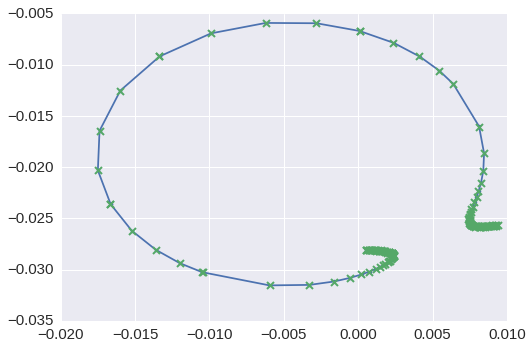

In [93]:
plot_ri(bif.model(),'.-')
plot_ri(bif.s21_data,'x',mew=2)

<function kid_readout.analysis.resonator.khalil.bifurcation_s21>

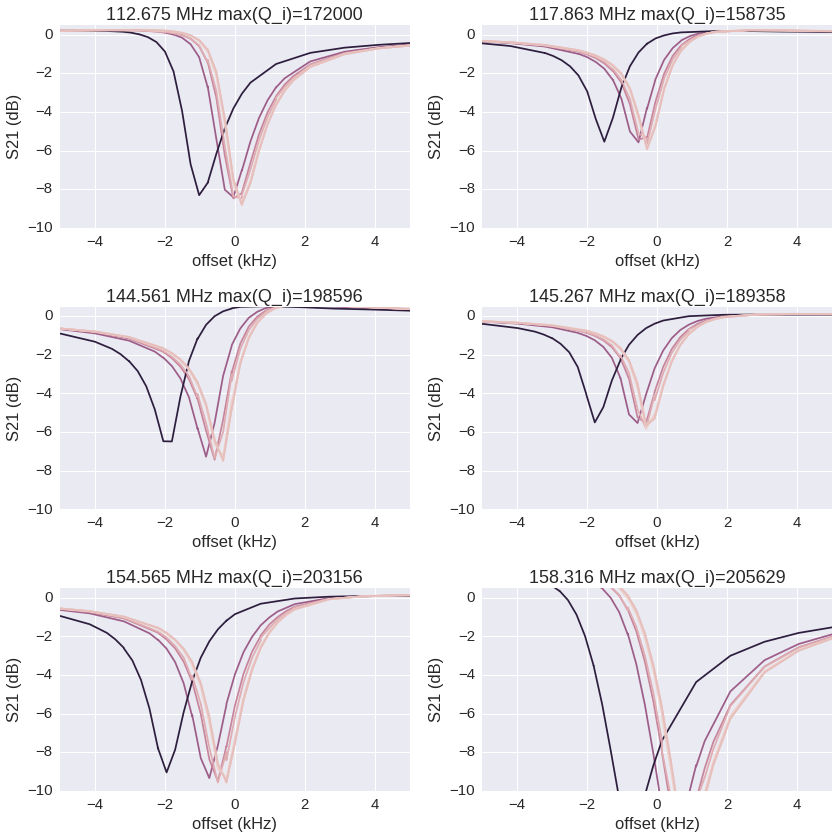

In [26]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39)]
    for m,row in dd.iterrows():
        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               color = get_color(row.package_temperature),
                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(-5,5)
    ax.set_ylim(-10,0.5)
    ax.set_ylabel('S21 (dB)')
    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

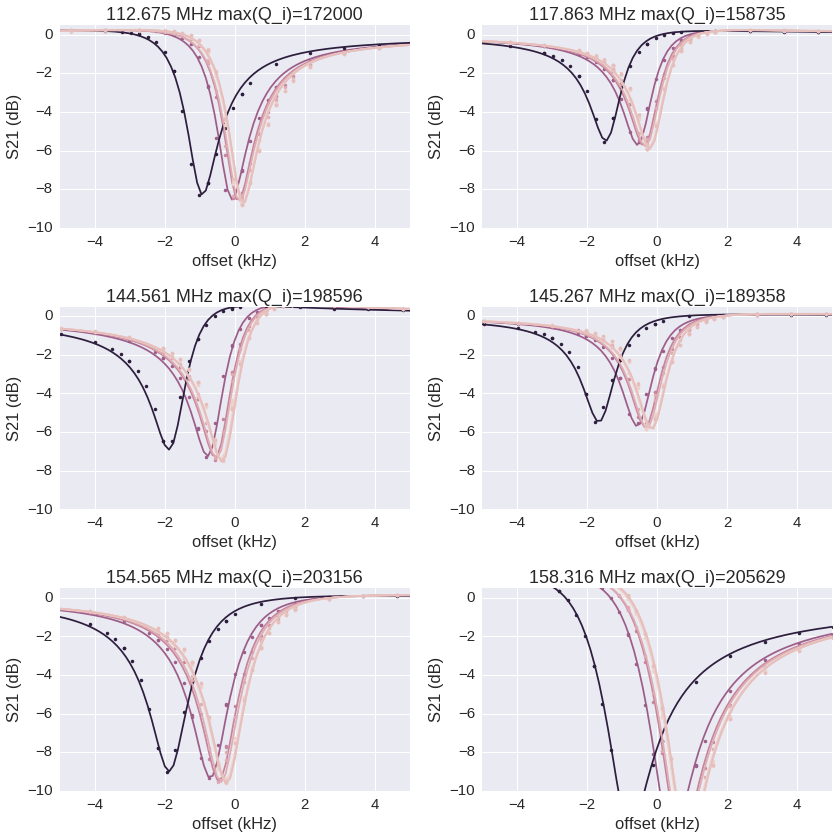

In [120]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39)]
    for m,row in dd.iterrows():
        ax.plot((row.res_model_frequency-dd.res_f_0.max())/1e3,dB(row.res_model_s21)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               color = get_color(row.package_temperature),)
        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               '.',color = get_color(row.package_temperature),
                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(-5,5)
    ax.set_ylim(-10,0.5)
    ax.set_ylabel('S21 (dB)')
    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

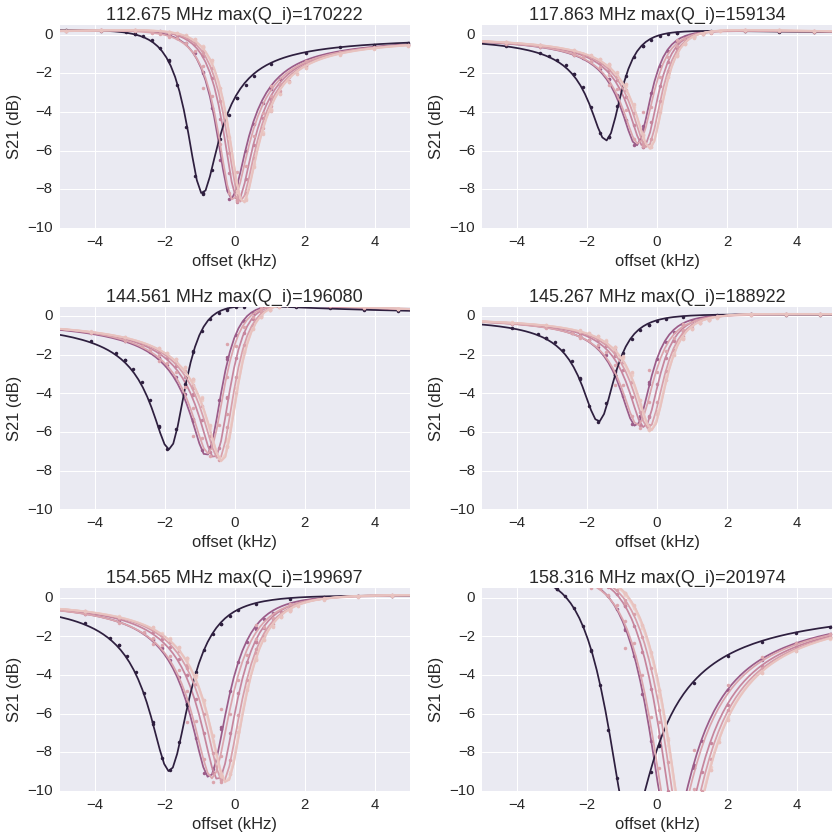

In [121]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==42)]
    for m,row in dd.iterrows():
        ax.plot((row.res_model_frequency-dd.res_f_0.max())/1e3,dB(row.res_model_s21)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               color = get_color(row.package_temperature),)
        ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
               '.',color = get_color(row.package_temperature),
                label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(-5,5)
    ax.set_ylim(-10,0.5)
    ax.set_ylabel('S21 (dB)')
    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

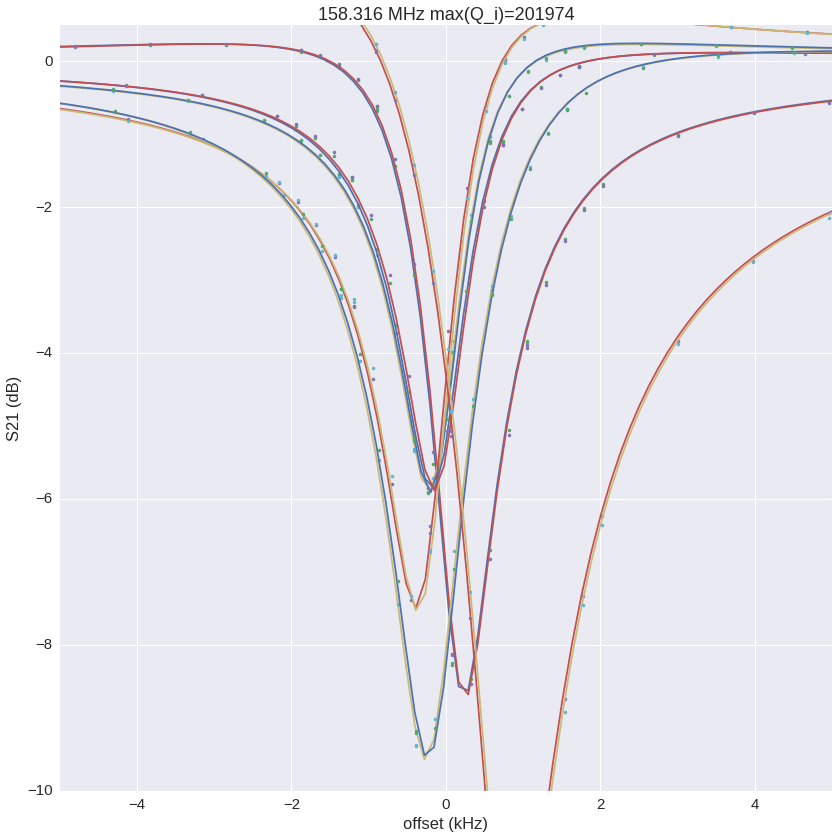

In [123]:
pal = sns.cubehelix_palette(as_cmap=True)
min_temp = df.package_temperature.min()
ptp_temp = df.package_temperature.ptp()
def get_color(t):
    return pal((row.package_temperature-min_temp)/ptp_temp)
fig,axs = subplots(1,1,figsize=(12,12))
for k,ax in enumerate([axs]):
    da = valid[(valid.roach_dac_attenuation==42)]
    da = da[da.package_temperature<0.067]
    for n in range(6):
        dd = da[da.number==n]
        for m,row in dd.iterrows():
            ax.plot((row.res_model_frequency-dd.res_f_0.max())/1e3,dB(row.res_model_s21)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
                   )
            ax.plot((row.res_frequency_data-dd.res_f_0.max())/1e3,dB(row.res_s21_data)-max([dB(row.res_s21_data[ii]) for ii in [0,-1]]),
                   '.',
                    label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(-5,5)
    ax.set_ylim(-10,0.5)
    ax.set_ylabel('S21 (dB)')
    ax.set_xlabel('offset (kHz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

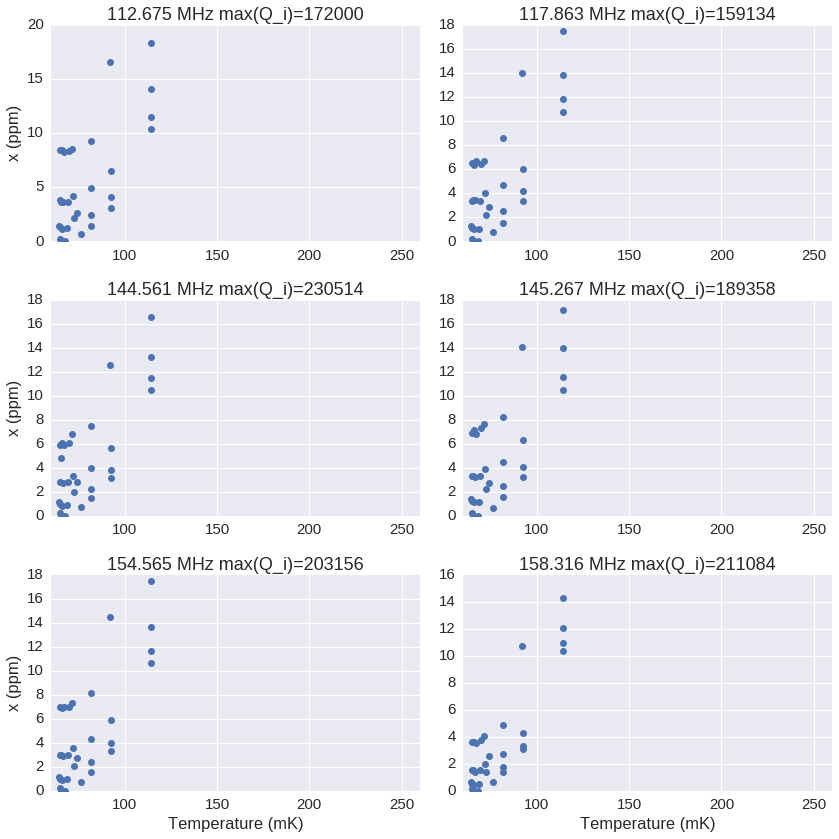

In [27]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,1e6*(1-dd.res_f_0/dd.res_f_0.max()),'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,260)
    #ax.set_ylim(-10,1200)
for ax in axs[:,0]:
    ax.set_ylabel('x (ppm)')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

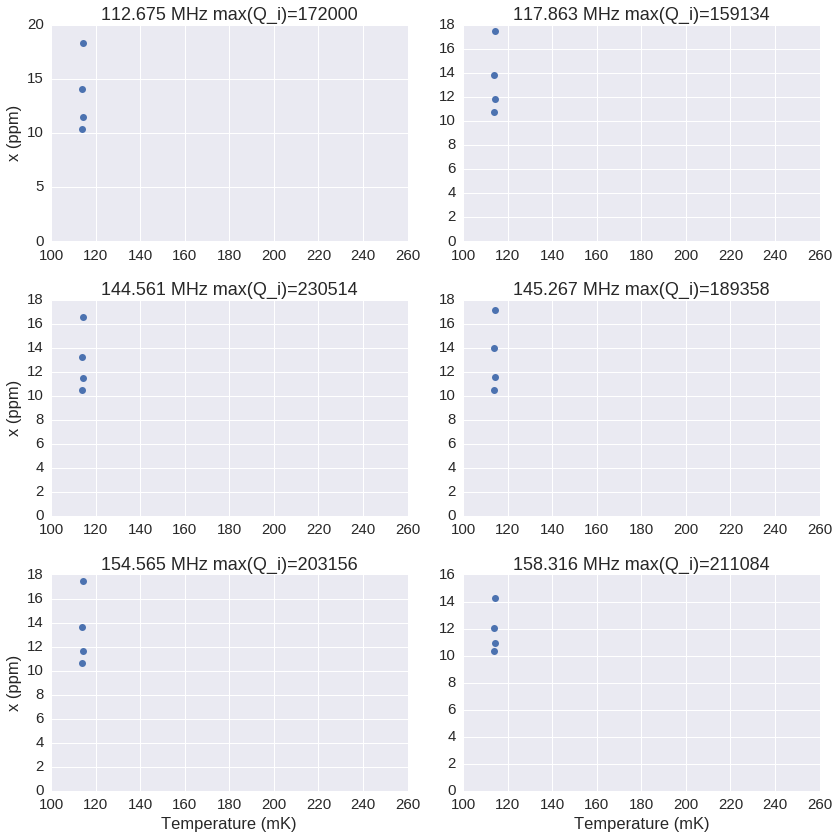

In [28]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,1e6*(1-dd.res_f_0/dd.res_f_0.max()),'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(100,260)
    #ax.set_ylim(-10,1200)
for ax in axs[:,0]:
    ax.set_ylabel('x (ppm)')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

In [66]:
from scipy.constants import c, h, k as k_B, pi
N0 = 1.72e10

In [97]:
from scipy.special import i0,k0

In [69]:
i0?

In [98]:
def xqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return ((alpha_k/(2*delta))*
           (1+(np.sqrt(2*delta/(pi*k_B*T))*
              np.exp(-h*f/(2*k_B*T))*
              i0(h*f/(2*k_B*T))))*
            np.sqrt(2*pi*k_B*T*delta)*np.exp(-delta/(k_B*T)))
def qiqp(T,alpha_k=1,Tc=.73,f=150e6):
    delta = Tc*k_B*1.76
    return (pi*np.exp(delta/(k_B*T))/
           (4*alpha_k*np.sinh(h*f/(2*k_B*T))*
           k0(h*f/(2*k_B*T))))

In [83]:
T = np.linspace(60e-3,200e-3,100)

In [102]:
dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39)]
x = 1e6*(1-dd.res_f_0/dd.res_f_0.max())
tt = dd.package_temperature
mask = tt<.2
x = x[mask]
tt = tt[mask]
qi = 1e6/dd.res_Q_i
qi = qi[mask]

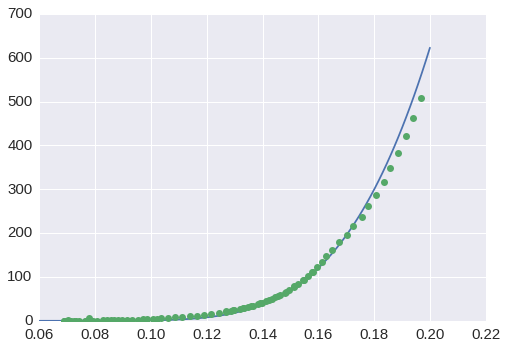

In [96]:
plot(T,1e6*xqp(T)*.26)
plot(tt,x,'o')
#ylim(0,40)
#yscale('log')

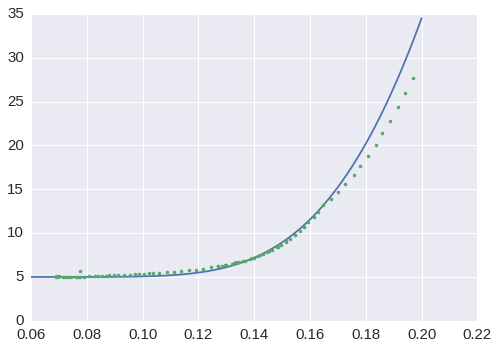

In [112]:
plot(T,.25*1e6/qiqp(T,Tc=.76)+5)
plot(tt,qi,'.')

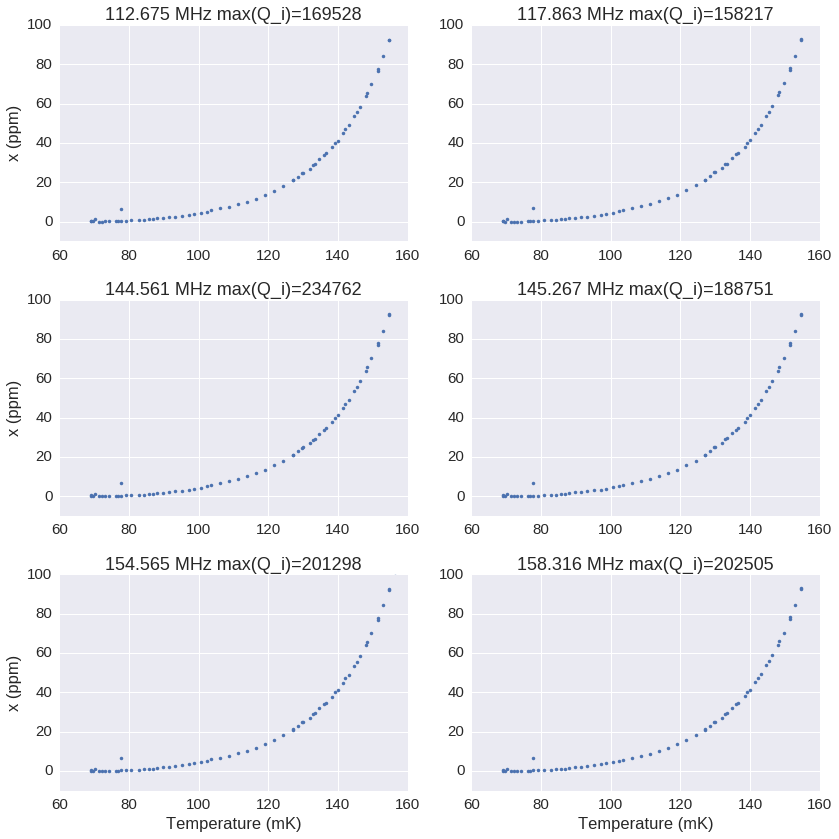

In [65]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39)]
    ax.plot(dd.package_temperature*1e3,1e6*(1-dd.res_f_0/dd.res_f_0.max()),'.')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,160)
    ax.set_ylim(-10,100)
for ax in axs[:,0]:
    ax.set_ylabel('x (ppm)')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

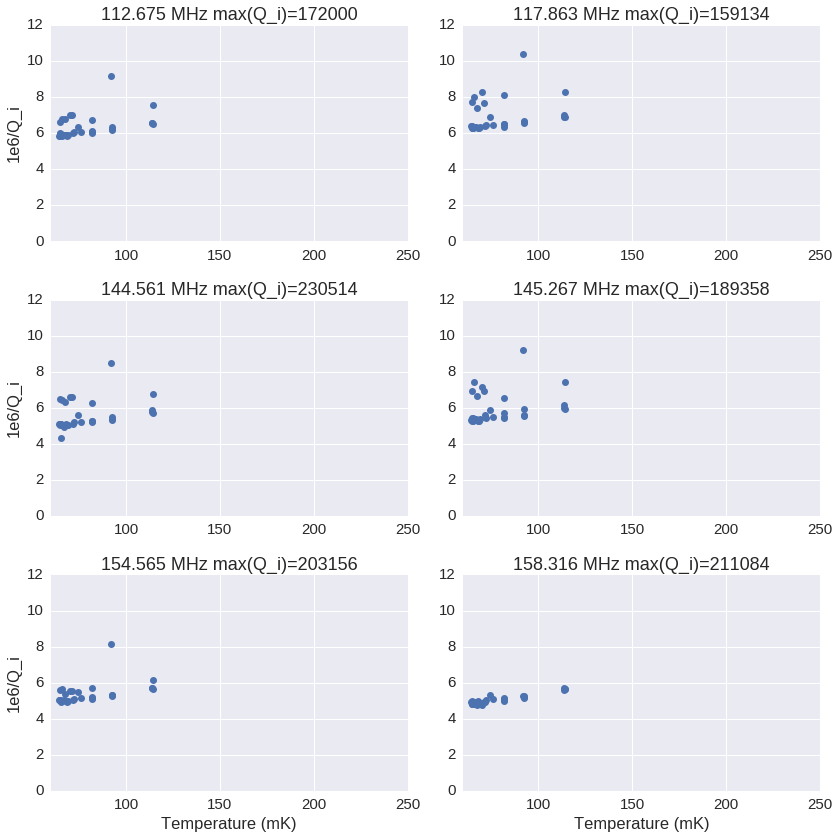

In [40]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,1e6/dd.res_Q_i,'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,250)
    ax.set_ylim(0,12)
for ax in axs[:,0]:
    ax.set_ylabel('1e6/Q_i')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

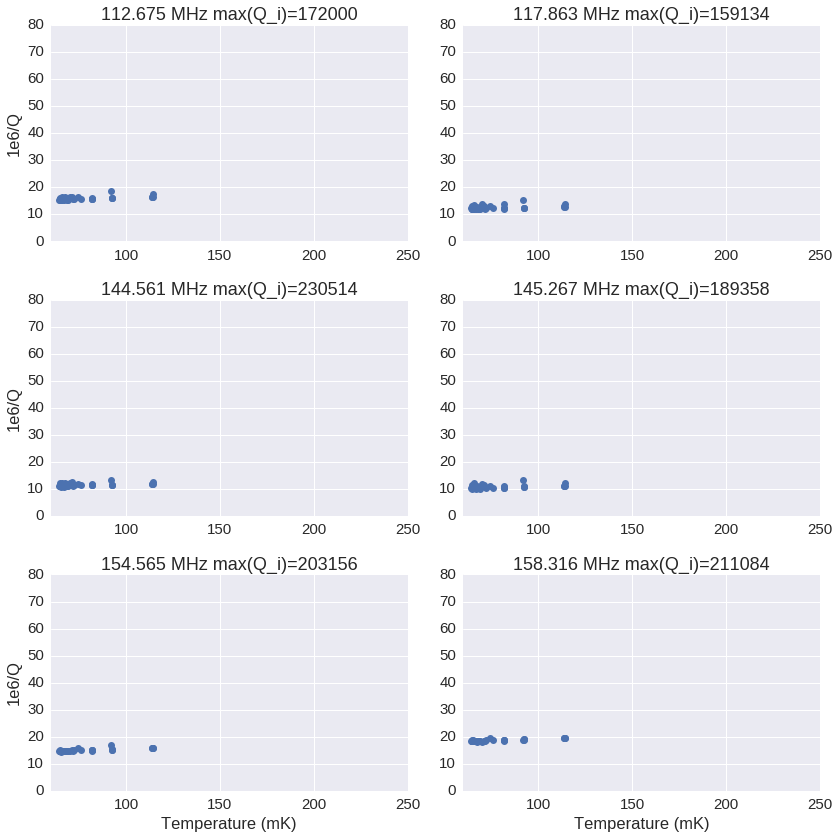

In [41]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,1e6/dd.res_Q,'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,250)
    ax.set_ylim(0,80)
for ax in axs[:,0]:
    ax.set_ylabel('1e6/Q')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

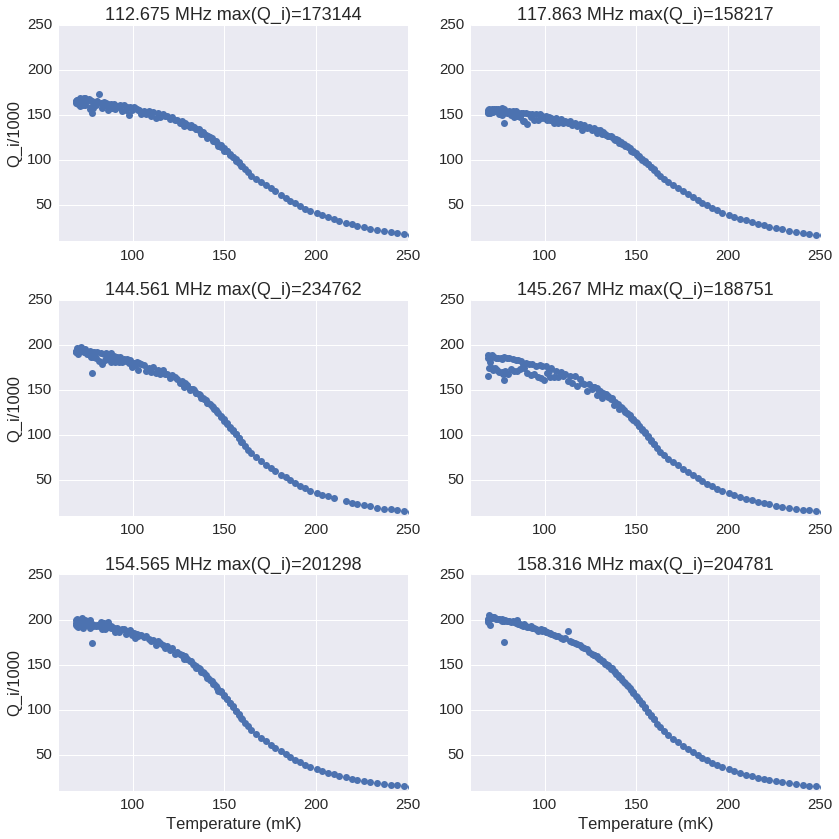

In [51]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,dd.res_Q_i/1000,'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,250)
    ax.set_ylim(10,250)
for ax in axs[:,0]:
    ax.set_ylabel('Q_i/1000')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

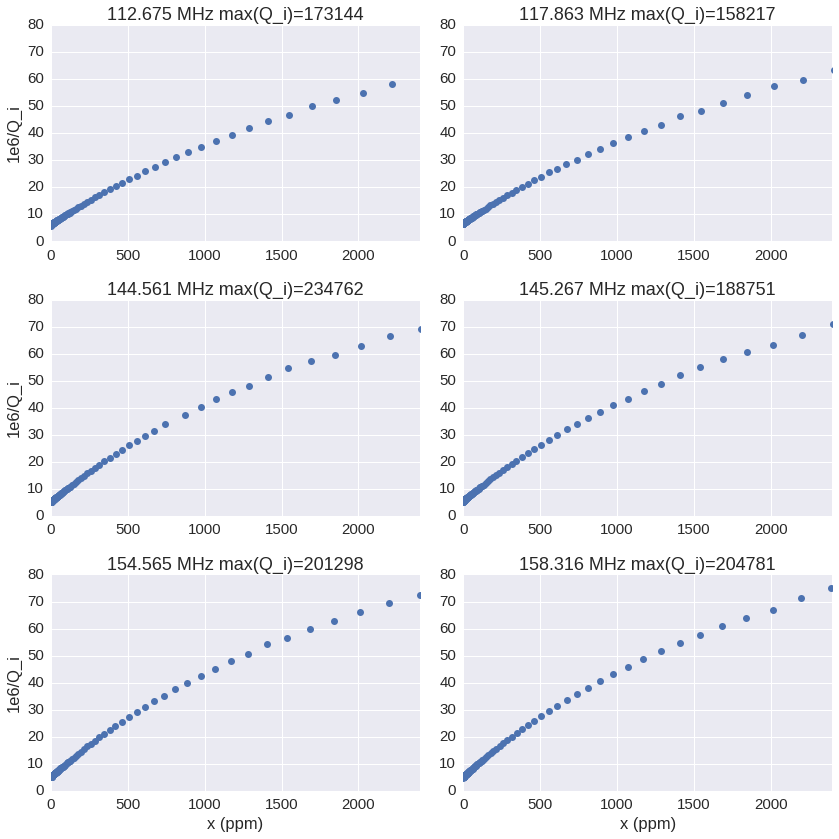

In [52]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(1e6*(1-dd.res_f_0/dd.res_f_0.max()),1e6/dd.res_Q_i,'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(0,2400)
    ax.set_ylim(0,80)
for ax in axs[:,0]:
    ax.set_ylabel('1e6/Q_i')
for ax in axs[-1,:]:
    ax.set_xlabel('x (ppm)')
fig.tight_layout()

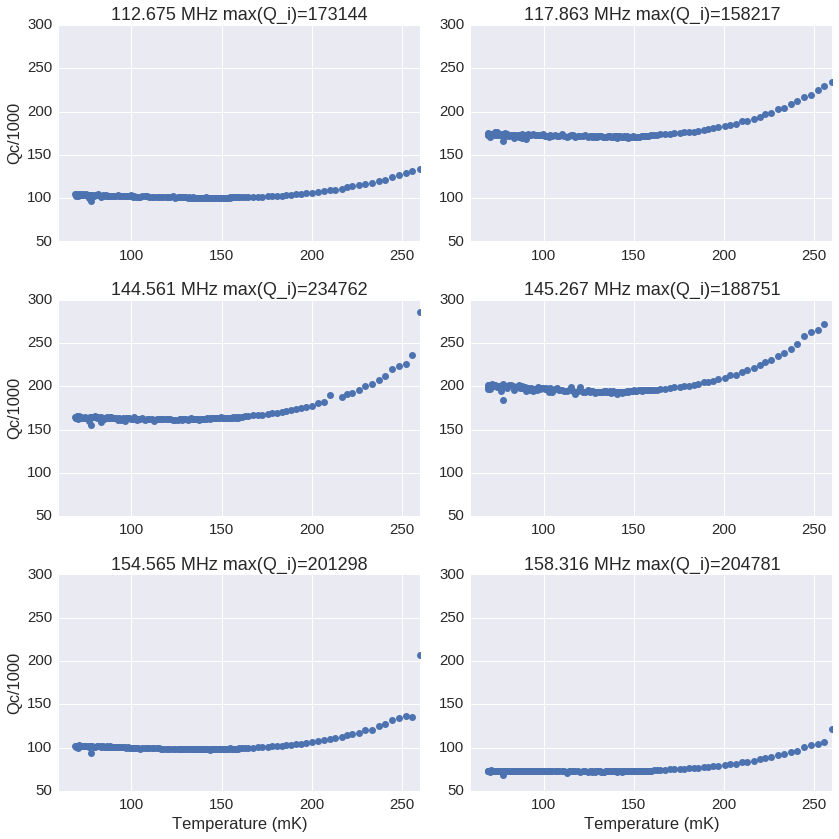

In [53]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    ax.plot(dd.package_temperature*1e3,1e-3/np.real(1/dd.res_Q_e),'o')
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
    ax.set_xlim(60,260)
    ax.set_ylim(50,300)
for ax in axs[:,0]:
    ax.set_ylabel('Qc/1000')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

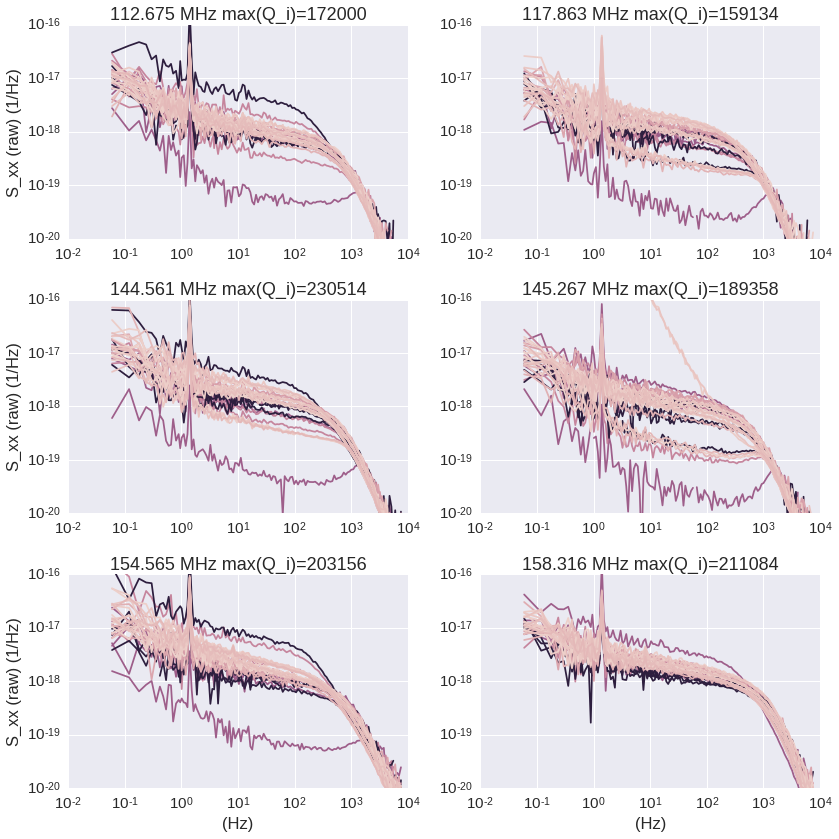

In [29]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx-row.S_yy,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

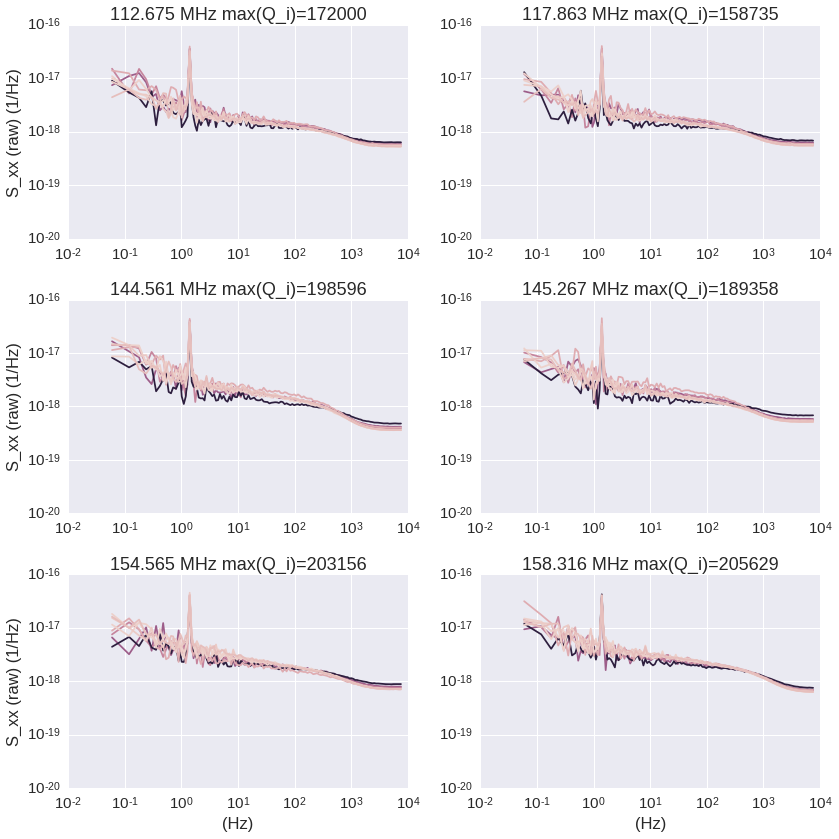

In [30]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39)]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

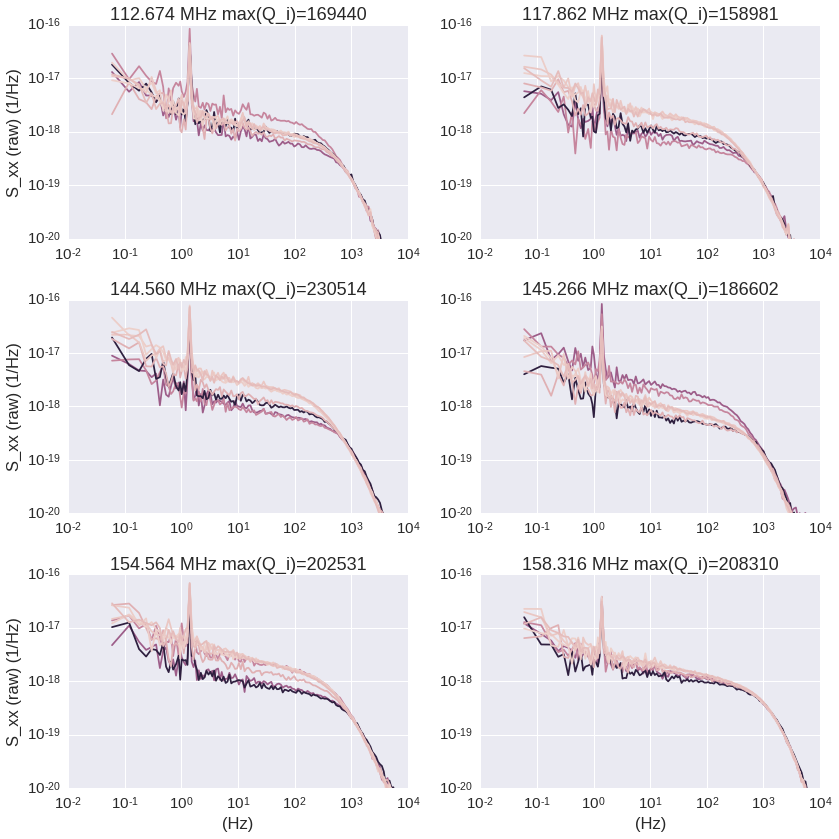

In [31]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==36)]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx-row.S_yy[-10:].mean(),
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

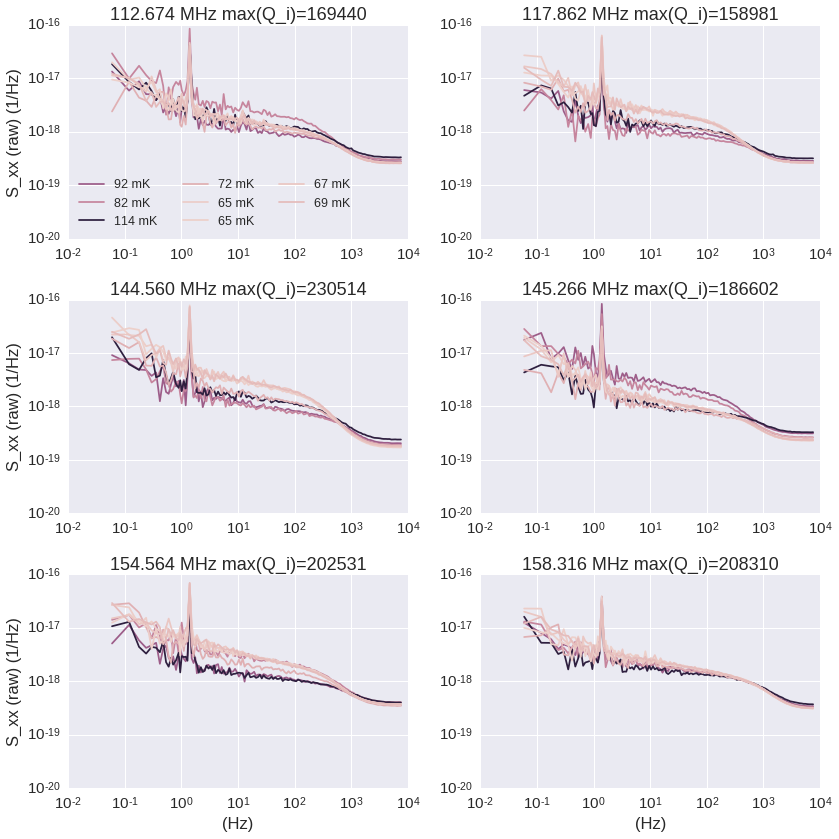

In [32]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==36)]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

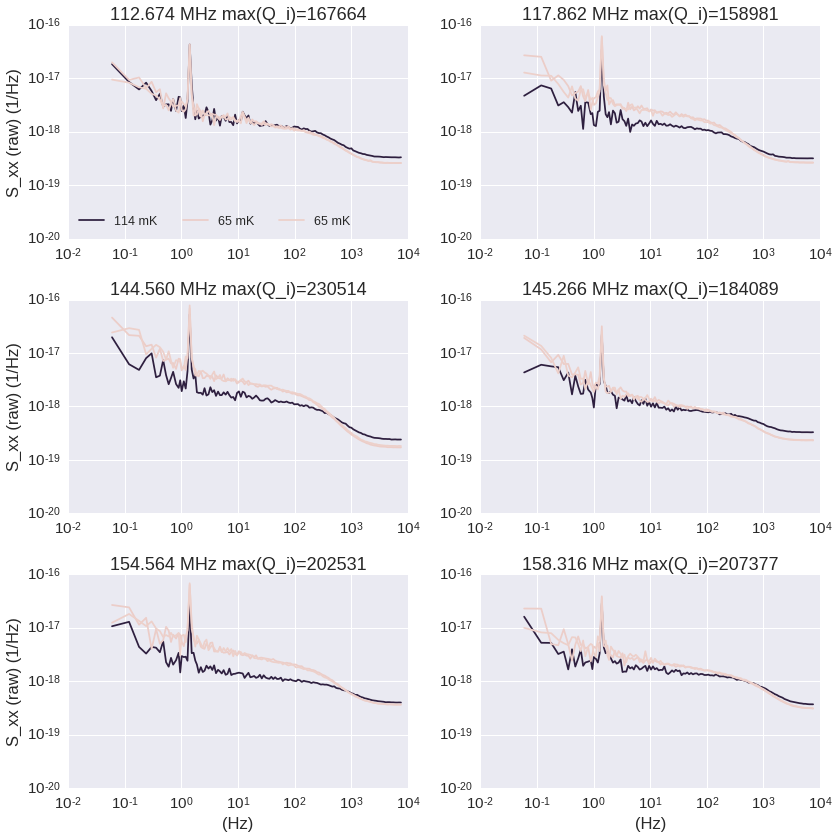

In [33]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==36) 
               & ((valid.package_temperature>100e-3) | (valid.package_temperature < 66e-3))]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

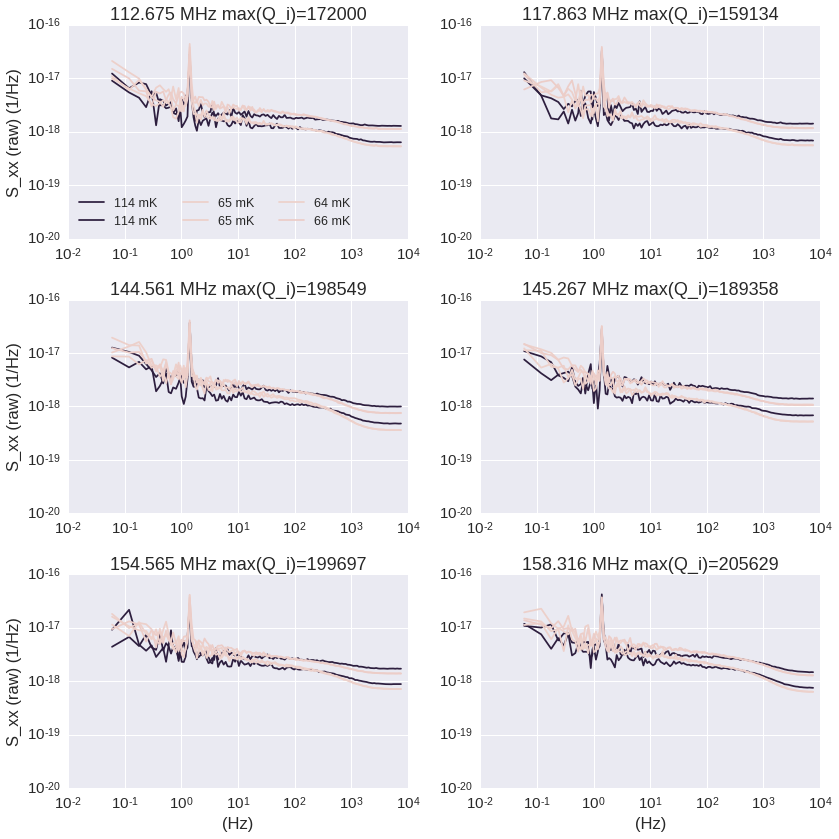

In [124]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & ((valid.roach_dac_attenuation==39) |  (valid.roach_dac_attenuation==42))
               & ((valid.package_temperature>100e-3) | (valid.package_temperature < 66e-3))]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

In [129]:
dd = valid[(valid.number==2) & ((valid.roach_dac_attenuation==39) |  (valid.roach_dac_attenuation==42))
               & ((valid.package_temperature>100e-3) | (valid.package_temperature < 66e-3))]

In [130]:
dd.shape

(6, 68)

In [131]:
np.savez('/artemis/readout/archive/2016-12-21-stanford-almn-res2-noise.npz',records = dd.to_records())

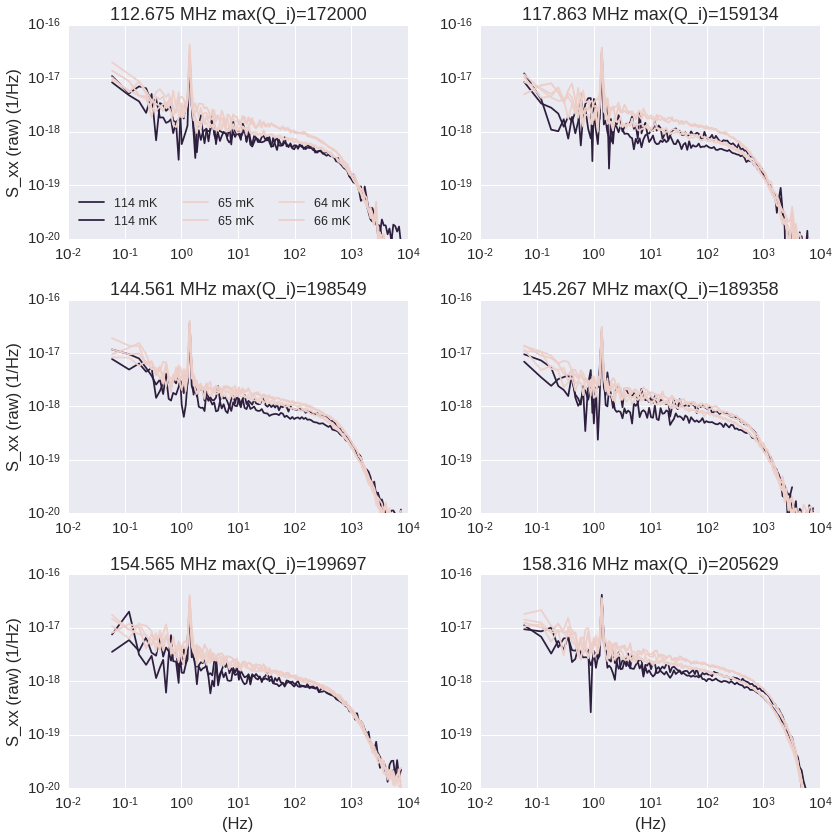

In [125]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & ((valid.roach_dac_attenuation==39) |  (valid.roach_dac_attenuation==42))
               & ((valid.package_temperature>100e-3) | (valid.package_temperature < 66e-3))]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx-np.median(row.S_yy[-20:]),
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

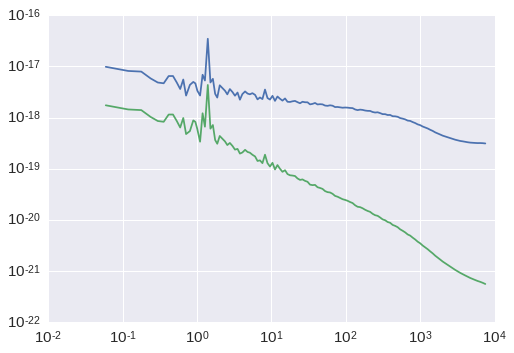

In [34]:
loglog(row.S_frequency,row.S_xx)
loglog(row.S_frequency,np.sqrt(row.S_xx*row.S_xx_variance))

In [36]:
valid.shape

(192, 67)

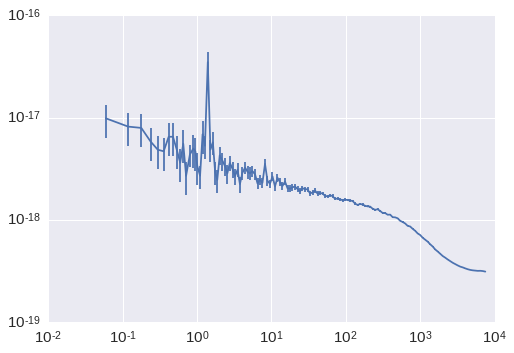

In [37]:
errorbar(row.S_frequency,row.S_xx,yerr=2*np.sqrt(row.S_xx*row.S_xx_variance))
xscale('log')
yscale('log')

In [38]:
import sys

In [42]:
sys.path

['',
 '/home/gjones/anaconda/envs/readout/lib/python27.zip',
 '/home/gjones/anaconda/envs/readout/lib/python2.7',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/plat-linux2',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/lib-tk',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/lib-old',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/lib-dynload',
 '/home/gjones/.local/lib/python2.7/site-packages',
 '/home/gjones/kid_readout',
 '/home/gjones',
 '/home/gjones/crabgp',
 '/home/gjones/python',
 '/data/home/gjones/anaconda/envs/readout/lib/python2.7/site-packages/Sphinx-1.3.5-py2.7.egg',
 '/data/home/gjones/anaconda/envs/readout/lib/python2.7/site-packages/setuptools-20.3-py2.7.egg',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/site-packages',
 '/home/gjones/anaconda/envs/readout/lib/python2.7/site-packages/IPython/extensions',
 '/data/home/gjones/.ipython']

In [34]:
from fit_power_spectra import fitter

In [35]:
mcf = fitter.MCRedWhiteNoiseRolloffPowerSpectrumFitter(row.S_frequency,row.S_xx,row.S_counts)

In [36]:
mcf.estimate_parameter_limits()

In [37]:
mcf.make_initial_guesses()

In [38]:
mask=mcf.suggest_outliers_to_prune()
mask = mask & (row.S_frequency > 10)

AttributeError: 'MCRedWhiteNoiseRolloffPowerSpectrumFitter' object has no attribute 'map_params'

In [ ]:
mcf2 = fitter.MCRedWhiteNoiseRolloffPowerSpectrumFitter(row.S_frequency[mask],row.S_xx[mask]*1e18,row.S_counts[mask])

In [ ]:
mcf2.estimate_parameter_limits()
mcf2.limits[2] = (10,100e6)
mcf2.make_initial_guesses()
mcf2.auto_run_mcmc()
mcf2.sampler.reset()
mcf2.run_mcmc(samples=20000,burnin=200)

In [108]:
mcf2.limits

[(0.031231267746081336, 2.6643647504777164),
 (0, 2.6643647504777164),
 (10, 100000.0),
 (0.1, 3),
 (10.371208190917969, 7521.1822986602783)]

In [ ]:
_=mcf2.corner()

In [57]:
row.res_f_0/(2*row.res_Q)

1460.4238915256965

In [ ]:
mcf2.plot_results(num_samples=100,alpha=.1,plot_limits=False)
axhline(0.299+.12)

In [76]:
mcf2.sampler.flatchain.mean(0)

array([  3.81304114e-01,   2.98406515e-01,   1.39248263e+03,
         3.15117232e-01,   1.02198413e+03])

In [78]:
mcf2.model.labels

['$N_i$', '$N_o$', '$f_{knee}$', '$\\alpha$', '$f_{3dB}$']

In [87]:
m = fitter.models.RedWhiteNoisePowerSpectrumModel(_76[0],_76[2],_76[3])

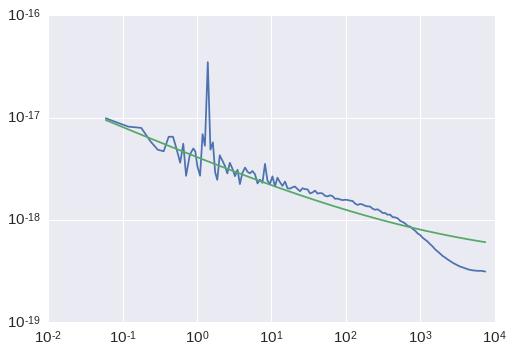

In [88]:
loglog(row.S_frequency,row.S_xx)
loglog(row.S_frequency,(m.psd(row.S_frequency))*1e-18)

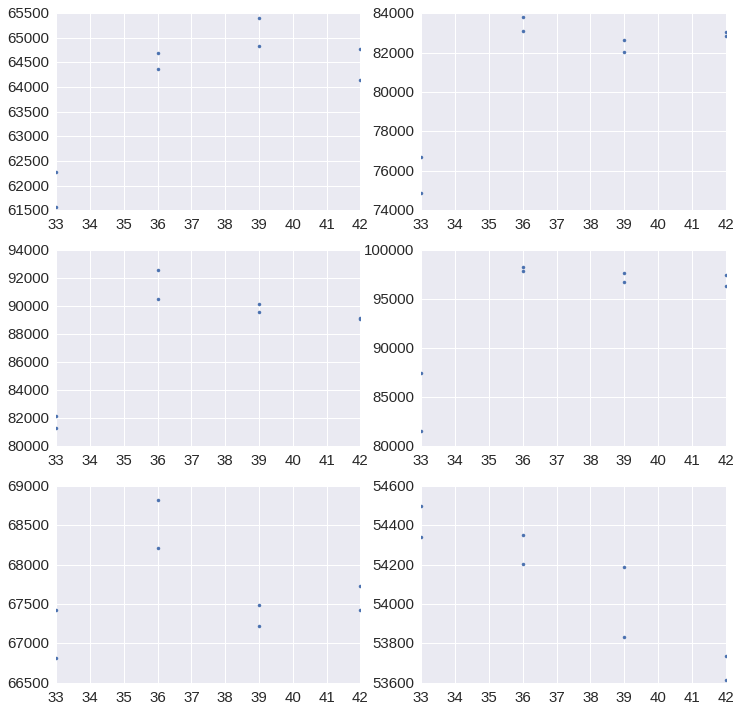

In [84]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) 
               & ((valid.package_temperature < 66e-3))]
    ax.plot(dd.roach_dac_attenuation,dd.res_Q,'.')

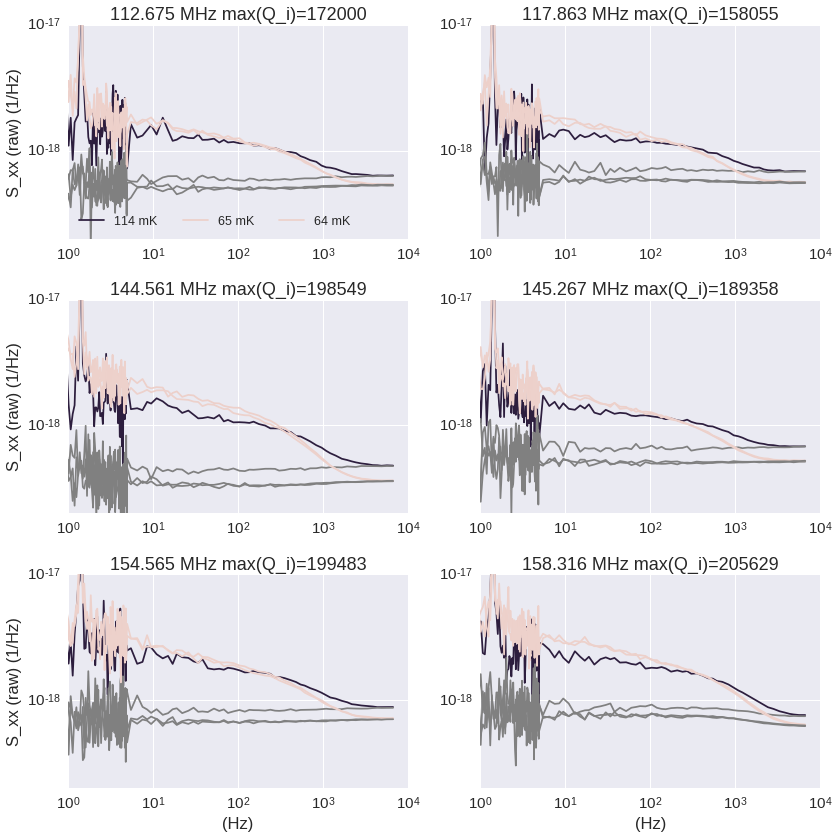

In [86]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) & (valid.roach_dac_attenuation==39) 
               & ((valid.package_temperature>100e-3) | (valid.package_temperature < 66e-3))]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
        ax.loglog(row.S_frequency,row.S_yy,color='gray')
    ax.set_ylim(2e-19,1e-17)
    ax.set_xlim(1,1e4)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

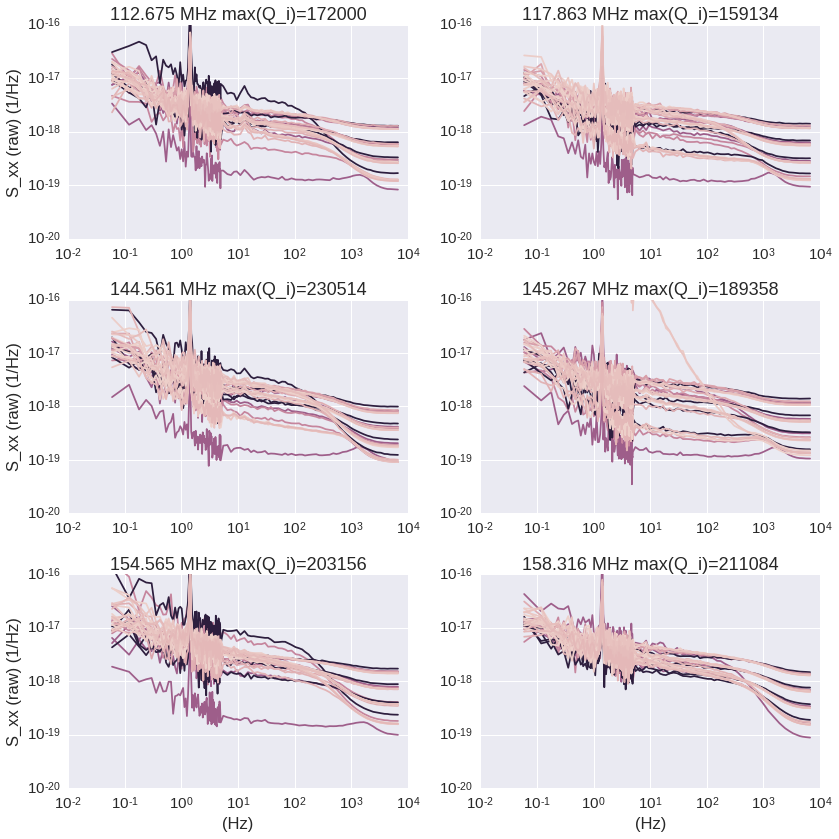

In [72]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k) ]
    for m,row in dd.iterrows():
        ax.loglog(row.S_frequency,row.S_xx,
                  color = get_color(row.package_temperature),
                 label=('%.0f mK' % (1e3*row.package_temperature)))
    ax.set_ylim(1e-20,1e-16)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S_xx (raw) (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('(Hz)')
#axs[0,0].legend(loc='lower left',prop=dict(size='x-small'),ncol=3)
fig.tight_layout()

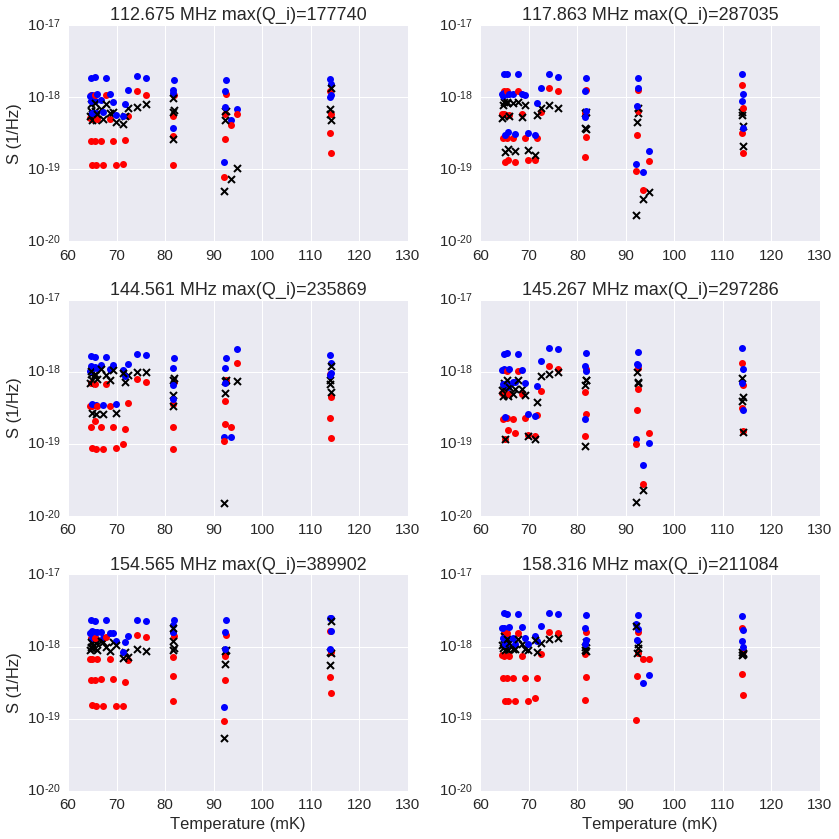

In [37]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        mask = (row.S_frequency>100) & (row.S_frequency<500)
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_xx[mask]),'bo')
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_yy[mask]),'ro')
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_xx[mask])-np.median(row.S_yy[mask]),'kx',mew=2)
    ax.set_ylim(1e-20,1e-17)
    ax.set_xlim(60,130)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

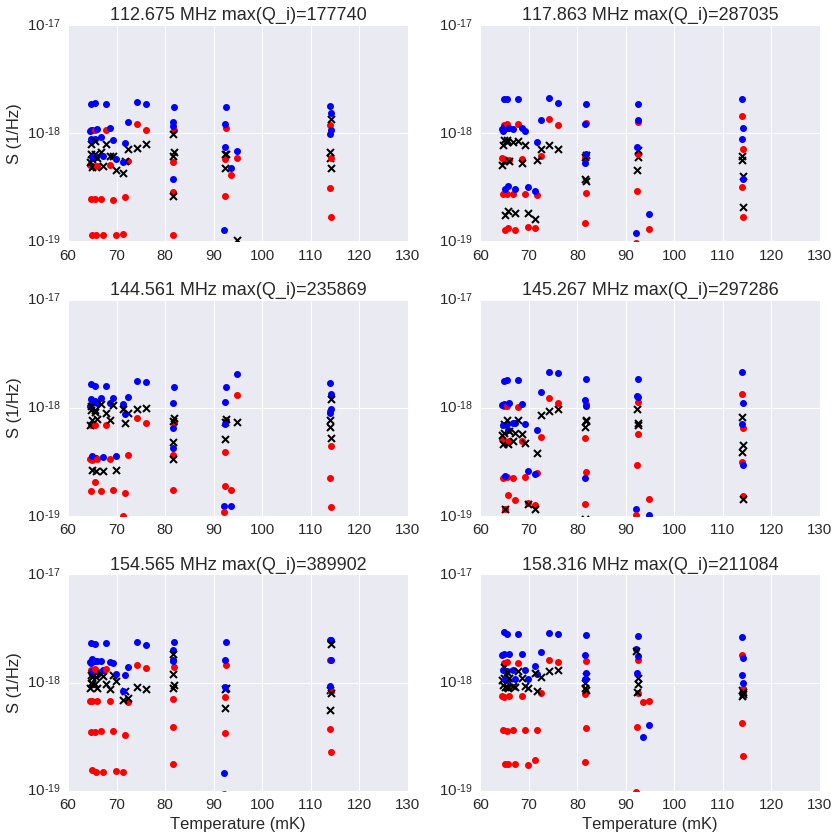

In [36]:
fig,axs = subplots(3,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        mask = (row.S_frequency>100) & (row.S_frequency<500)
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_xx[mask]),'bo')
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_yy[mask]),'ro')
        ax.semilogy(row.package_temperature*1e3,np.median(row.S_xx[mask])-np.median(row.S_yy[mask]),'kx',mew=2)
    ax.set_ylim(1e-19,1e-17)
    ax.set_xlim(60,130)
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('Temperature (mK)')
fig.tight_layout()

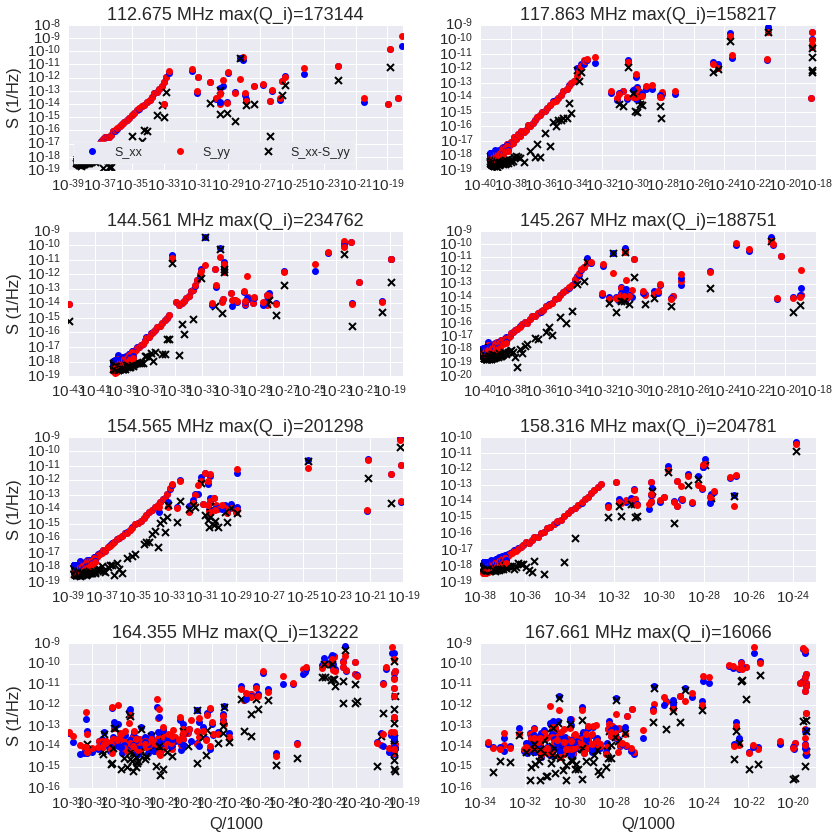

In [58]:
fig,axs = subplots(4,2,figsize=(12,12))
for k,ax in enumerate(axs.flatten()):
    dd = valid[(valid.number==k)]
    for m,row in dd.iterrows():
        mask = (row.S_frequency>100) & (row.S_frequency<500)
        ax.loglog(1/row.res_Q**8,np.median(row.S_xx[mask]),'bo')
        ax.loglog(1/row.res_Q**8,np.median(row.S_yy[mask]),'ro')
        ax.loglog(1/row.res_Q**8,np.median(row.S_xx[mask])-np.median(row.S_yy[mask]),'kx',mew=2)
    #ax.set_ylim(1e-20,1e-12)
    #ax.set_xlim(2e-40,1e-32)
    ax.set_xlim()
    ax.set_title('%.3f MHz max(Q_i)=%.0f' % (dd.res_f_0.max()/1e6,dd.res_Q_i.max()))
for ax in axs[:,0]:
    ax.set_ylabel('S (1/Hz)')
for ax in axs[-1,:]:
    ax.set_xlabel('Q/1000')
axs[0,0].legend(['S_xx','S_yy','S_xx-S_yy'],loc='lower left',prop=dict(size='x-small'),ncol=3,frameon=True)
fig.tight_layout()